/home/miguelm/.local/lib/python3.8/site-packages/healpy/newvisufunc.py:273: UserWarning: 
 *** Overriding default plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.05, 'cbar_label_pad': -8, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn(
/home/miguelm/.local/lib/python3.8/site-packages/healpy/newvisufunc.py:277: UserWarning: 
 *** New plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.05, 'cbar_label_pad': -8, 'figure_width': 10, 'figure_size_ratio': 0.6} ***
  warnings.warn("\n *** New plot properies: " + str(plot_properties) + " ***")


<Figure size 720x504 with 0 Axes>

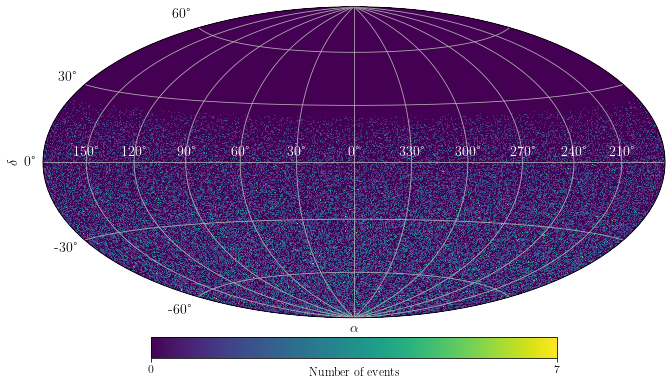

In [5]:
#---------------------------------------
# Try optimize the code!!!!
#---------------------------------------
import math
import numpy as np 
import healpy as hp
from healpy.newvisufunc import projview

#for plotting 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc

#to import and work with data frames 
import pandas as pd

#to work with time and angular coordinates in the celeastial sphere
from astropy.time import Time

%matplotlib inline

rc('font',**{'family':'serif','serif':['DejaVu Sans']})
rc('text', usetex=True)

#convert a set of pandas columns into a list of event 
def pandas_to_event(df, str1 , str2, str3, str4):
    
    alpha = np.radians(df[str1].to_numpy())
    delta = np.radians(df[str2].to_numpy())
    time = df[str3].to_numpy()
    energy = df[str4].to_numpy()
    
    evt_list = []
    
    for i in range(len(alpha)):
        evt_list.append([alpha[i],delta[i],time[i],energy[i]])
        
    return evt_list

#convert equatorial coordinates of event into healpy coordinates 
def Healpy_Event(evt_list):
        
    new_evt_list = []
    
    for evt in evt_list:
        evt[1] = math.pi/2 - evt[1]
        new_evt_list.append(evt)
    
        
    return new_evt_list

#convert equatorial coordinates into healpy coordinates 
def ToHealpyCoordinates(alpha, dec):
    
    return alpha, np.pi/2 - dec

#convert healpy coordinates into Equatorial Coordinates
def ToEquatorialCoordinates(phi, theta):
    
    return phi, np.pi/2 - theta

#convert parquet to healpy map 
def FileToHealpyMap(filename, df_columns, NSIDE):
    
    data = pd.read_parquet(filename, engine = 'fastparquet')
    
    #save right ascencion and declination 
    ra_vec = data[df_columns[0]].to_numpy()
    dec_vec = np.pi/2 - data[df_columns[1]].to_numpy()
    
    #vector to save sky indexes
    hp_indexes = []
    
    #for pos in coordinates:
    hp_indexes.append(hp.ang2pix(NSIDE, dec_vec, ra_vec))
        
    #create vectors with zeros and length equal to number of pixels
    skymap = np.zeros(hp.nside2npix(NSIDE))
    
    #at the indexes specified earlier, place the corresponding number of events
    np.add.at(skymap, tuple(hp_indexes), 1)
    
    return skymap

#-------------------------------
# main 
#-------------------------------
path2file_ud = '../DataSets/Vertical/MockData_Repeaters/Repeater_RandPosAndDate_large_stats/'

#defines the characteristics of the repeater to be read
DATE = 'RandPosAndDate'
PERIOD = '3600'
N_EVENTS = '100000'
REP_TOTAL_INTENSITY = '200'
REP_INTENSITY = '5'


filename_ud = 'IsoBG_ExpRepeater_%s_Period_%s_TotalEvents_%s_AcceptedRepEvents_%s_RepIntensity_%s_3843630_1.parquet' % (DATE, PERIOD, N_EVENTS, REP_TOTAL_INTENSITY, REP_INTENSITY)

#defines the NSIDE parameter (aka number of pixels <-> angular resolution)
NSIDE = 128

ud_skymap = FileToHealpyMap(path2file_ud + filename_ud, ['rep_ud_ra', 'rep_ud_dec'], NSIDE)

#create figure
fig = plt.figure(figsize=(10,7)) #create figure

#plot sky map 
projview(
    ud_skymap,
    graticule=True,
    graticule_labels=True,
    #title=r"Instantaneous exposure for " + str(theta_min) + r"$^\circ < \theta < $ " + str(theta_max) + r"$^\circ$ on " + str(t.fits),
    unit="Number of events",
    xlabel=r"$\alpha$",
    ylabel=r"$\delta$",
    cb_orientation="horizontal",
    projection_type="hammer",
    fontsize={'title':16, 'xlabel':14, 'ylabel':14, 'xtick_label':14, 'ytick_label':14},
    override_plot_properties={'figure_width':10, 'figure_size_ratio':0.6},
    longitude_grid_spacing = 30,
    latitude_grid_spacing = 30,
    xtick_label_color='white'
)

plt.savefig('Skymap_REP_%s_Period_%s_NEvents_%s_AcceptedRepEvents_%s_RepIntensity_%s.pdf' % (DATE, PERIOD, N_EVENTS, REP_TOTAL_INTENSITY, REP_INTENSITY),dpi=500)


67538.46442892586


/home/miguelm/.local/lib/python3.8/site-packages/healpy/newvisufunc.py:273: UserWarning: 
 *** Overriding default plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.05, 'cbar_label_pad': -8, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn(
/home/miguelm/.local/lib/python3.8/site-packages/healpy/newvisufunc.py:277: UserWarning: 
 *** New plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.05, 'cbar_label_pad': -8, 'figure_width': 10, 'figure_size_ratio': 0.6} ***
  warnings.warn("\n *** New plot properies: " + str(plot_properties) + " ***")


<Figure size 720x504 with 0 Axes>

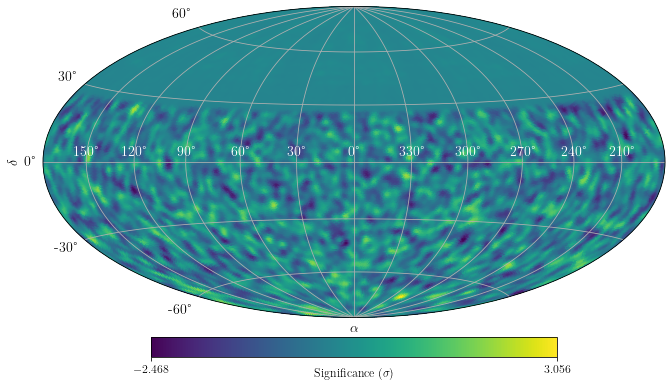

In [8]:
#defines the top-hat function for the computation of the LiMa significance
def top_hat_beam(radius, NSIDE):
    
    b = np.linspace(0.0, np.pi, 10000)
    bw = np.where(abs(b) <= radius, 1, 0)
    return hp.sphtfunc.beam2bl(bw, b, lmax=NSIDE*3) #beam in the spherical harmonics space

def TopHatSmoothedMap(hp_map, radius, NSIDE):
    
    solid_angle = 2.*np.pi*(1. - np.cos(radius))
    
    return hp.smoothing(hp_map, beam_window=top_hat_beam(radius, NSIDE)) / solid_angle

#compute the total exposure and the integrated exposure per solid angle
def integrated_exposure(theta_min, theta_max, a_cell, time_begin, time_end, time, station_array):

    #to select only the stations within the time period time_begin < time < time_end
    time_indexes = np.where(np.logical_and(time > time_begin, time < time_end))[0]

    return (math.pi/2)*(math.cos(2*theta_min) - math.cos(2*theta_max))*a_cell*sum(station_array[time_indexes])

#compute the relative exposure per solid angle
def relative_exposure(dec, lat_auger, theta_min, theta_max):
    
    xi_max = (math.cos(theta_max) - math.sin(lat_auger)*math.sin(dec))/(math.cos(lat_auger)*math.cos(dec))
    
    if ( xi_max > 1):
        h_max = 0
    elif (xi_max < -1):
        h_max = math.pi
    else:
        h_max = math.acos(xi_max)
        
    
    xi_min = (math.cos(theta_min) - math.sin(lat_auger)*math.sin(dec))/(math.cos(lat_auger)*math.cos(dec))
    
    if ( xi_min > 1):
        h_min = 0
    elif (xi_min < -1):
        h_min = math.pi
    else:
        h_min = math.acos(xi_min)
        
    return math.cos(lat_auger)*math.cos(dec)*(math.sin(h_max) - math.sin(h_min)) + (h_max - h_min)*math.sin(lat_auger)*math.sin(dec)

#creates the smooth map using the top hat proceedure
topHat_smoothing_radius = math.radians(2)

#creates smoothed top and Gaussian smoothed count maps
topHat_smooth_skymap_ud = TopHatSmoothedMap(ud_skymap,topHat_smoothing_radius, NSIDE)
Gauss_smooth_skymap_ud = hp.smoothing(ud_skymap, sigma=0.5*topHat_smoothing_radius)

#read the relavant info from the event selection files 
path_to_selection = '../Tau_Distribution/results/'
selection_info_file = 'AugerOpenData_VerticalEvents_SelectionInfo.parquet'
selection_info = pd.read_parquet(path_to_selection + selection_info_file, engine='fastparquet')

#latitude and longitude of the Pierre Auger Observatory
lat_auger = math.radians(-35.23)

#values of the maximum and minimum values of theta. In this case we are considering vertical events
theta_min = math.radians(float(selection_info.iloc[0]['Theta_min']))
theta_max = math.radians(float(selection_info.iloc[0]['Theta_max']))

#set value of unit cell of array according to distance between stations
lattice_parameter = 1.5 #in kilometers
a_cell = .5*math.sqrt(3)*lattice_parameter ** 2 

#set time interval in seconds
time_begin = Time(selection_info.iloc[0]['t_begin'], format='fits').gps
time_end = Time(selection_info.iloc[0]['t_end'], format='fits').gps

#load station data
station_data = pd.read_parquet('../DataSets/Auger_Hexagons/Hexagons_NoBadStations.parquet', engine='fastparquet')

time = station_data['gps_time'].to_numpy()
n5T5 = station_data['n5T5'].to_numpy()
n6T5 = station_data['n6T5'].to_numpy()

#compute time integrated exposure
total_exposure = integrated_exposure(theta_min, theta_max, a_cell, time_begin, time_end, time, (2/3)*n5T5 + n6T5)/(365*24*60) #per year per sr per km^2

print(total_exposure)

#get the angles of each pixel in skymap 
exp_theta, exp_phi = hp.pix2ang(NSIDE, np.arange(hp.nside2npix(NSIDE)))

exp_alpha, exp_dec = ToEquatorialCoordinates(exp_phi, exp_theta)

exp_map_indexes = []
exp_map_content = []

for i in range(len(exp_phi)):
    
    exp_map_indexes.append(hp.ang2pix(NSIDE, exp_theta[i], exp_phi[i]))
    exp_map_content.append(relative_exposure(exp_dec[i], lat_auger, theta_min, theta_max))

#computes the normalization of the relative exposure 
exposure_normalization = sum(exp_map_content)

#produce vector with 0's
exp_skymap = np.zeros(hp.nside2npix(NSIDE))

np.add.at(exp_skymap, exp_map_indexes, np.multiply(exp_map_content, total_exposure/exposure_normalization))

#produce the LI and MA significance map
def LiMaSignificance(LiMa_alpha, N_on, N_off):
    
    log_N_on = (1. + LiMa_alpha)*N_on / (LiMa_alpha*(N_on + N_off))
    log_N_off = (1. + LiMa_alpha)*N_off / (N_on + N_off)
    
    #to avoid negative values, induced by smoothing, in the arg of logs
    sig_2 = np.zeros(len(N_on))
    
    positive_indexes = np.where(np.logical_and(N_on > 0, LiMa_alpha > 0))
    sig_2[positive_indexes] += N_on[positive_indexes]*np.log(log_N_on[positive_indexes])
    
    positive_indexes = np.where(N_off > 0)
    sig_2[positive_indexes] += N_off[positive_indexes]*np.log(log_N_off[positive_indexes])
              
    return np.sqrt(2*np.abs(sig_2))*np.sign(N_on - LiMa_alpha*N_off)

#smooth exposure maps
topHat_smooth_exposure_skymap = TopHatSmoothedMap(exp_skymap,topHat_smoothing_radius, NSIDE)
Gauss_smooth_exposure_skymap = hp.smoothing(exp_skymap, sigma=0.5*topHat_smoothing_radius)

#define the number of pixels per region 
region_solid_angle = 2*math.pi*(1 - math.cos(topHat_smoothing_radius))
solid_angle_per_pix = 4*math.pi / hp.nside2npix(NSIDE)
npix_per_region = region_solid_angle / solid_angle_per_pix
              
#define the LiMa_alpha, N_on and N_off 
LiMa_LiMa_alpha = topHat_smooth_exposure_skymap / (np.sum(exp_skymap) / npix_per_region - topHat_smooth_exposure_skymap)
N_on = topHat_smooth_skymap_ud*npix_per_region 
N_off = np.sum(ud_skymap) - N_on 

#make the significance map 
significance_map = LiMaSignificance(LiMa_LiMa_alpha, N_on, N_off)
Gaussian_significance_map = hp.smoothing(significance_map, sigma=0.5*topHat_smoothing_radius)

#creates mask to avoid showing pixels in region where exposure is null
mask = np.zeros(hp.nside2npix(NSIDE))
mask[hp.query_strip(NSIDE, np.pi/2-(theta_max + lat_auger), 0)] = 1

#create figure
fig = plt.figure(figsize=(10,7)) #create figure

#plot sky map 
projview(
    Gaussian_significance_map,
    graticule=True,
    graticule_labels=True,
    #title=r"Instantaneous exposure for " + str(theta_min) + r"$^\circ < \theta < $ " + str(theta_max) + r"$^\circ$ on " + str(t.fits),
    unit=r"Significance ($\sigma$)",
    xlabel=r"$\alpha$",
    ylabel=r"$\delta$",
    cb_orientation="horizontal",
    #max = max(significance_map),
    #min = -max(significance_map),
    projection_type="hammer",
    fontsize={'title':16, 'xlabel':14, 'ylabel':14, 'xtick_label':14, 'ytick_label':14},
    override_plot_properties={'figure_width':10, 'figure_size_ratio':0.6},
    longitude_grid_spacing = 30,
    latitude_grid_spacing = 30,
    xtick_label_color='white'
)

plt.savefig('SkyMap_GaussianSmooth_LiMaSignificance_REP_%s_Period_%s_NEvents_%s_AcceptedRepEvents_%s_RepIntensity_%s.pdf' % (DATE, PERIOD, N_EVENTS, REP_TOTAL_INTENSITY, REP_INTENSITY),dpi=500)
